In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [5]:
# Load the datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [6]:
# Convert date columns to datetime

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], errors='coerce') 



In [7]:
# Feature Engineering for transactions
transaction_features = transactions.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

In [8]:
# Merge the customer profile with transaction features
customer_features = customers.merge(transaction_features, on="CustomerID", how="left")



In [9]:
# Fill missing values if any
customer_features.fillna(0, inplace=True)


In [10]:
# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['total_spending', 'num_transactions', 'avg_transaction_value']])


In [11]:
# Perform K-means clustering for different cluster numbers (2 to 10)
inertia = []  # To store inertia values for the Elbow Method
db_index_scores = []  # To store DB index scores

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    db_index_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))


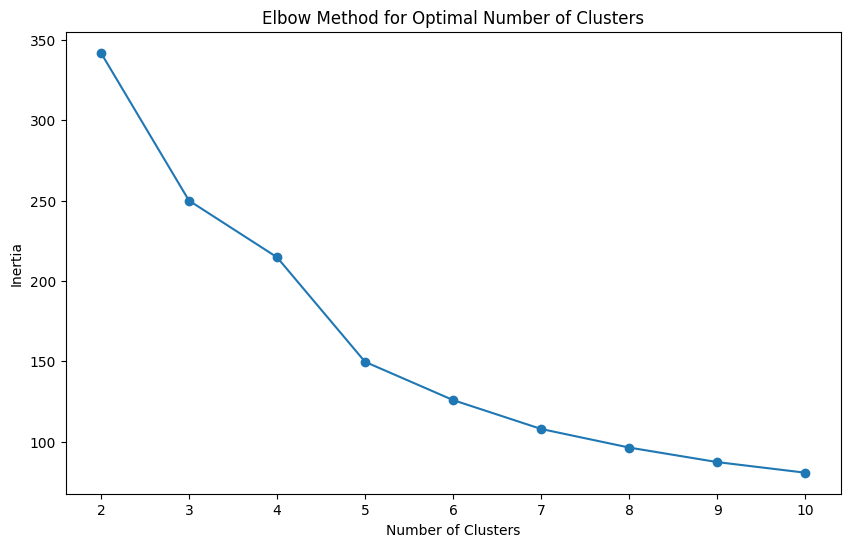

In [12]:
# Plot the elbow method to choose optimal clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


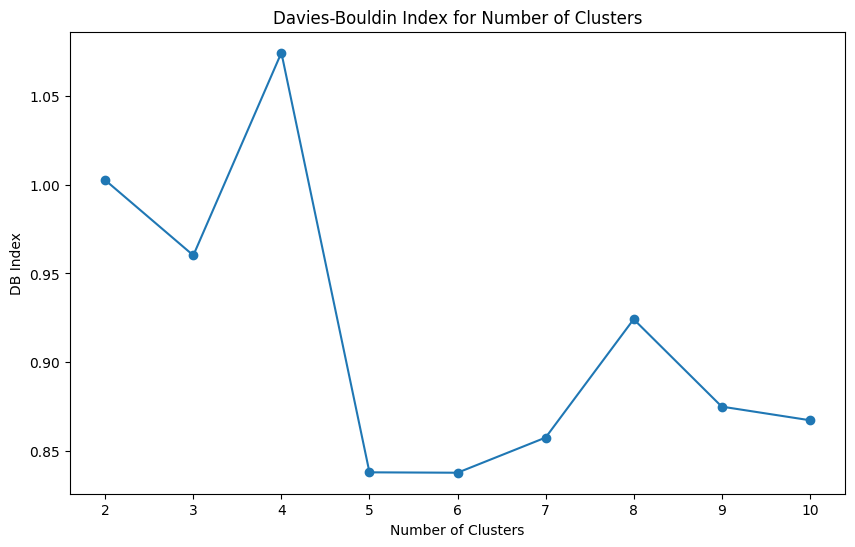

In [13]:
# Plot DB Index scores to find the best clustering
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_index_scores, marker='o')
plt.title('Davies-Bouldin Index for Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()


In [14]:
# Choose the best number of clusters based on the DB index or elbow method
optimal_clusters = 3  # Choose this based on the plots, assume it's 3 for example


In [15]:
# Run K-means with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['cluster'] = kmeans.fit_predict(scaled_features)


In [16]:
# Compute DB Index for the selected clusters
db_index = davies_bouldin_score(scaled_features, customer_features['cluster'])
print(f"DB Index for {optimal_clusters} clusters: {db_index}")


DB Index for 3 clusters: 0.9601803766785171


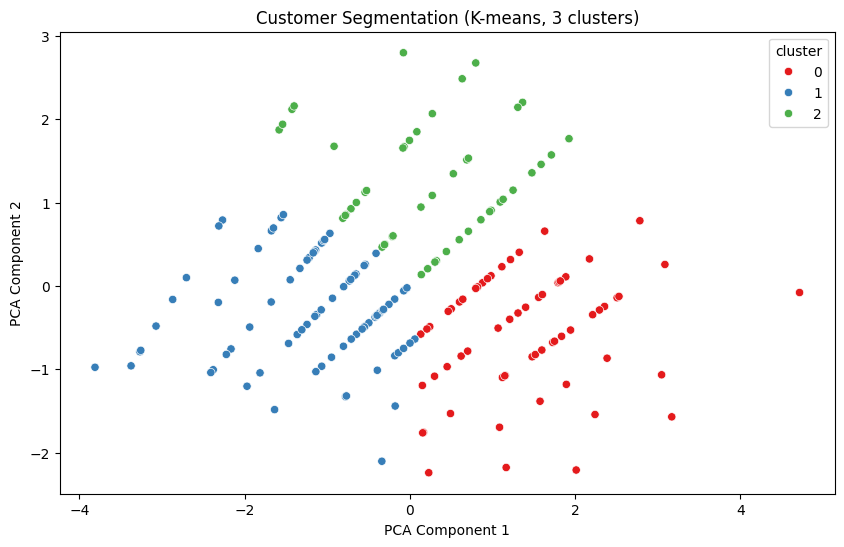

In [17]:
# Visualize the clusters using PCA (for 2D visualization)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_features['cluster'], palette="Set1")
plt.title(f'Customer Segmentation (K-means, {optimal_clusters} clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [18]:
# Save the results to a CSV file
customer_features[['CustomerID', 'cluster']].to_csv('Customer_Segmentation.csv', index=False)
